In [1]:
from functions2 import *
import numpy as np
import numpy as np
import math
from scipy import optimize
import pylab as pl
from IPython import display as dp

# Model Parameters:

In [2]:
T = 5
time_step = 6/12
range_ = np.arange(time_step,T+time_step,time_step)
vol_window = 3000
term_window= 6000
interpol_method = 'spline' #NelsonSiegel
solver_method = 'BFGS'

# Load historical rates

Total of nulls RIFLGFCM01_N.B    10505
RIFLGFCM03_N.B     5610
RIFLGFCM06_N.B     5610
RIFLGFCY01_N.B      627
RIFLGFCY02_N.B     4219
RIFLGFCY03_N.B      627
RIFLGFCY05_N.B      627
RIFLGFCY07_N.B     2497
RIFLGFCY10_N.B      627
RIFLGFCY20_N.B     8545
RIFLGFCY30_N.B     5391
dtype: int64

 Total of nulls 0


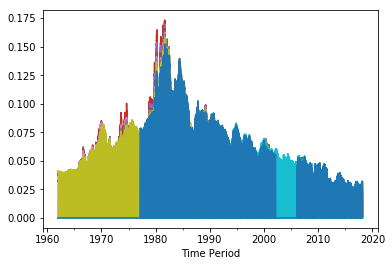

In [3]:
data,data_ = load_data()
data_.plot(legend=False);

In [4]:
data_.describe().T

,count,mean,std,min,25%,50%,75%,max
RIFLGFCM01_N.B,14648.0,0.003438,0.009859,0.0,0.0000,0.0000,0.000200,0.0527
RIFLGFCM03_N.B,14648.0,0.024658,0.031562,0.0,0.0000,0.0019,0.050900,0.1549
RIFLGFCM06_N.B,14648.0,0.025814,0.032749,0.0,0.0000,0.0036,0.052200,0.1567
RIFLGFCY01_N.B,14648.0,0.049706,0.034993,0.0,0.0215,0.0507,0.069600,0.1731
RIFLGFCY02_N.B,14648.0,0.038511,0.040236,0.0,0.0000,0.0274,0.064700,0.1695
RIFLGFCY03_N.B,14648.0,0.053818,0.033880,0.0,0.0293,0.0548,0.073725,0.1659
RIFLGFCY05_N.B,14648.0,0.056421,0.032627,0.0,0.0351,0.0565,0.076200,0.1627
RIFLGFCY07_N.B,14648.0,0.052373,0.037146,0.0,0.0206,0.0562,0.077100,0.1605
RIFLGFCY10_N.B,14648.0,0.059692,0.030774,0.0,0.0400,0.0583,0.077600,0.1584
RIFLGFCY20_N.B,14648.0,0.019807,0.025517,0.0,0.0000,0.0000,0.044900,0.0830


In [5]:
(data_.isnull()).sum()

RIFLGFCM01_N.B    0
RIFLGFCM03_N.B    0
RIFLGFCM06_N.B    0
RIFLGFCY01_N.B    0
RIFLGFCY02_N.B    0
RIFLGFCY03_N.B    0
RIFLGFCY05_N.B    0
RIFLGFCY07_N.B    0
RIFLGFCY10_N.B    0
RIFLGFCY20_N.B    0
RIFLGFCY30_N.B    0
dtype: int64

In [6]:
(data_==0).sum()

RIFLGFCM01_N.B    10595
RIFLGFCM03_N.B     5629
RIFLGFCM06_N.B     5610
RIFLGFCY01_N.B      627
RIFLGFCY02_N.B     4219
RIFLGFCY03_N.B      627
RIFLGFCY05_N.B      627
RIFLGFCY07_N.B     2497
RIFLGFCY10_N.B      627
RIFLGFCY20_N.B     8545
RIFLGFCY30_N.B     5391
dtype: int64

In [7]:
(np.isfinite(data_)).sum()

RIFLGFCM01_N.B    14648
RIFLGFCM03_N.B    14648
RIFLGFCM06_N.B    14648
RIFLGFCY01_N.B    14648
RIFLGFCY02_N.B    14648
RIFLGFCY03_N.B    14648
RIFLGFCY05_N.B    14648
RIFLGFCY07_N.B    14648
RIFLGFCY10_N.B    14648
RIFLGFCY20_N.B    14648
RIFLGFCY30_N.B    14648
dtype: int64

# Bootstrap

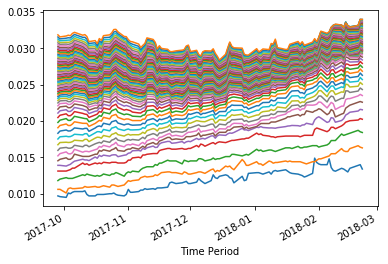

In [8]:
TS = BootStraper()
y = data_[-term_window:]
y=y[y!=0].dropna() #removing days in which yields where quoted as zero
x_= None
r = TS.BootStrap(x_,y,method=interpol_method)
r[-100:].plot(legend=False)

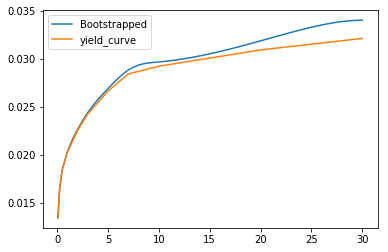

In [9]:
plt.plot(np.array(r.columns),r[-1:].as_matrix().flatten(),label='Bootstrapped');
plt.plot(TS.x,data_[-1:].as_matrix().flatten(),label='yield_curve');
plt.legend()

In [10]:
(r.isnull()).sum().sum()

20

In [11]:
r=r.dropna()

In [12]:
(r.isnull()).sum().sum()

0

# Interpolate strips

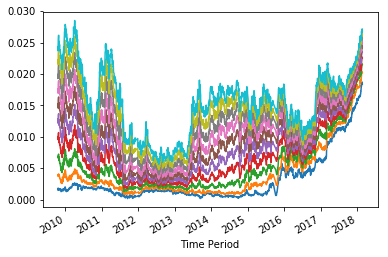

In [13]:
interpol = CubicS(x=np.array(r.columns),x_=range_)
f = interpol.spline
irs = pd.DataFrame(data=apply(f,r),index=r.index,columns=np.round(range_,2))
irs[-2000:].plot(legend=False);


# Volatility estimate

In [14]:
np.seterr(all='ignore') 
# it is expected to ger errors on the log because of
# divisions by zero. Those are removed from the data
# on the last lines
def get_vols(irs,vol_window):
    irs = irs[-vol_window:]
    ratio = irs[1:]/irs.shift(1)[1:]
    ratio = ratio[ratio.notnull()].copy()
    for i in ratio.columns:
        ratio = ratio[ratio[i].notnull()]
        log_ratio = np.log(ratio)
    log_ratio = log_ratio[log_ratio!=np.inf]
    log_ratio = log_ratio[log_ratio!=-np.inf]
    return np.std(log_ratio)

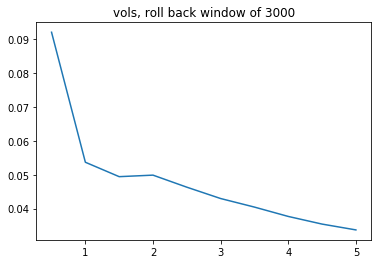

In [15]:
vols = get_vols(irs,vol_window)
plt.plot(vols)
plt.title('vols, roll back window of {}'.format(vol_window));

# Vasicek class: solve for model coeficients

Vasicek's model parameters can be solved by minimzing the loss function:

\begin{equation}
loss = \sum{\frac{1}{N}(P-P(0,T))^2} 
\end{equation}

The model for $P(0,T)$ is given by the following relations:

\begin{equation}
P(0,T) = A(T) exp^{-B(T)r_0}
\end{equation}
<br>
\begin{equation}
A(T) = exp{{\frac{(B(T)-T)(a^2b-\frac{\sigma^2}{2})}{a^2}}-\frac{\sigma^2B^2(T)}{4a}}
\end{equation}
<br>
\begin{equation}
B(T) = \frac{1-e^{-aT}}{a}
\end{equation}

The class Vasicek has this model implemented. It requires a time series with NelsonSiegel coeficients and the historical spot rates at a given set of maturities (ps). We use the method get_ps() on the previous cell to extract ps using NS.

In [16]:
class Vasicek():
    def __init__(self,rs,vol):
        self.t = rs.columns
        self.ps= rs[-1:]
        self.sigma = vol        
    
    def get_TheoreticalP(self,x=0):
        sigma = self.sigma
        try:
            _ = x.shape
        except:
            x = self.t
            
        a = self.a
        b = self.b
        B = (1-np.exp(-a*x))/a
        A = np.exp(((B-x)*(a**2*b-(sigma**2)/2))/a**2-(sigma**2*B**2)/(4*a))
        self.B=B
        self.A=A
        self.sim_p = A*np.exp(-B*x)
        self.r = -1*np.log(self.sim_p)/x
        return self.r

    
    def loss(self,x):
        self.a = x[0]
        self.b = x[1]   
        self.sim_rs = apply(self.get_TheoreticalP,self.ps)
        loss = np.array(self.ps.as_matrix())-np.array(self.sim_rs)

        loss = 10000*np.sum(loss**2)
        
        return loss

    
    def solve(self,x0=np.random.rand(2)):
        self.opt_results = optimize.fmin(self.loss,x0=x0)#,tol=1e-10,method='Nelder-Mead',options={'maxiter':1800})
        self.a = self.opt_results[0]
        self.b = self.opt_results[1]
        print(self.opt_results)
    
    def get_price_rate(self,T,r):
        
        sigma = self.sigma[T]
        T = T #self.t[T]
        a = self.a
        b = self.b
        B = (1-np.exp(-a*T))/a
        A = np.exp(((B-T)*((a**2)*b-(sigma**2)/2))/a**2-(sigma**2*B**2)/(4*a))
        p = A*np.exp(-B*r)
        r = -1*np.log(p)/T
        return p,r



In [17]:
V = Vasicek(irs,vols)
V.solve()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 60
         Function evaluations: 118
[-0.00031298  0.02096637]


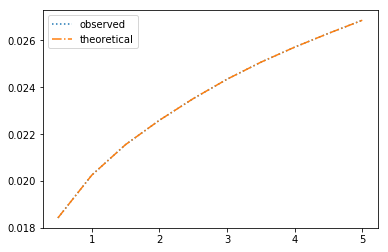

In [18]:
plt.plot(irs.columns,irs[-1:].as_matrix().flatten(),label='observed',linestyle=':');
plt.plot(V.r,label='theoretical',linestyle='-.')
plt.legend()

# Value an European call option on a zero coupon Bond

Vasicek model:

\begin{equation}
c = P(0,T)N(d) - X P(0,t)N(d-\sigma_p)
\end{equation}

\begin{equation}
d = \frac{1}{\sigma_p}ln(\frac{P(0,T)}{P(0,t)X})+\frac{1}{2}\sigma_p
\end{equation}

\begin{equation}
\sigma_p = \frac{\sigma}{a}(1-e^{(T-t)})\sqrt{\frac{1-e^{-2aT}}{2a}}
\end{equation}

ref: Professor Reduane lecture notes (Rotman School of Management)



# Using closed form solution

In [19]:
from scipy.stats import norm
def option_pricing(V,r,t,T,X):

    time_dict = dict(zip(V.t,np.arange(len(V.t))))
    
    r = r[-1:][t].item()
    
    P = V.get_price_rate(T,r)
    
    p = V.get_price_rate(t,r)
    
 
    sigmap = V.sigma[t]*(1/V.a)*(1-np.exp(-V.a*(T-t)))*np.sqrt((1-np.exp(-2*V.a*t))/(2*V.a))
    
    d = (1/sigmap)*np.log(P[0]/(p[0]*X))+0.5*sigmap
    
    c = P[0]*norm.cdf(d)-X*p[0]*norm.cdf(d-sigmap)
    
    return c
    
    
   

In [20]:
call_price = []
price_range = np.round(range_,2)
for i in price_range:
    T=5
    t=i
    X = .8
    i

    call_price.append(option_pricing(V,r=irs,t=t,T=T,X=X))

In [21]:
pd.DataFrame(data=call_price,index=price_range).T[[1,2,3,4]]

,1.0,2.0,3.0,4.0
0,0.164209,0.167584,0.162662,0.167662


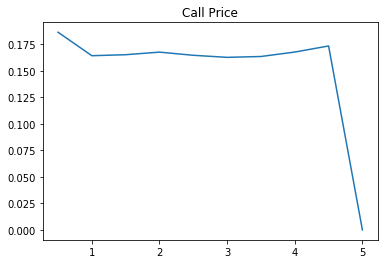

In [22]:
plt.plot(price_range,call_price)
plt.title('Call Price');

# Using stochastic simulation

Now lets use the parameters a and b to on a stochastic model:

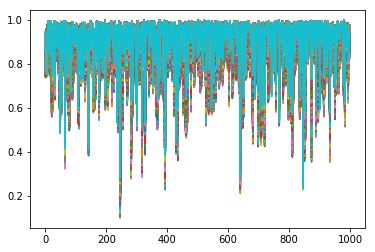

In [23]:
a = V.a
b = V.b
T = 4
sigma = V.sigma[T]
r0 = irs[-1:][T].item()
numint = 1000
numsim = 1010
dt = T/numint
series = a*(b-r0)*dt + sigma*np.random.randn(numint,numsim)
plt.plot(np.exp(-r0*np.cumprod(series+1,axis=1)*T));


In [24]:
CALL_price = np.maximum(np.exp(-r0*np.cumprod(series+1,axis=1)*T)-X,0)

In [25]:
PUT_price = np.maximum(X-np.exp(-r0*np.cumprod(series+1,axis=1)*T),0)

# European Call on a zero coupon bond

Price Histogram:

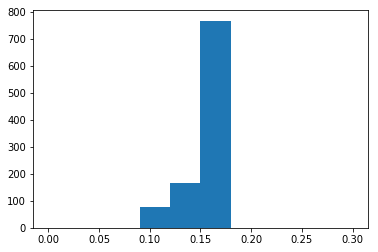

In [26]:
plt.hist(CALL_price[-1],range=(0,0.3));

In [27]:
print('European call on a zero coupon bond is: {}'.format(100*np.mean(CALL_price[-1])))

European call on a zero coupon bond is: 15.418669819194896


# American Call on a zero coupon bond

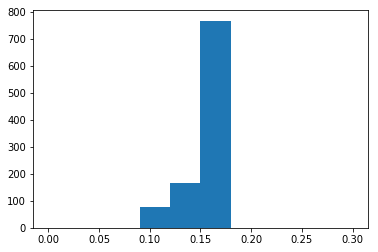

In [28]:
plt.hist(CALL_price[-1],range=(0,0.3));

In [29]:
print('American call on a zero coupon bond is: {}'.format(100*np.mean(CALL_price)))

American call on a zero coupon bond is: 11.371506647199952
